In [1]:

from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 3

seg_exper_handler = seg_exper_ensemble.seg_exper_handlers[TEST_FOLD]
seg_exper_handler.get_test_set()

  0%|          | 0/25 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:03<00:00,  7.59it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=3, quick_run=True, num_of_input_chnls=2)

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


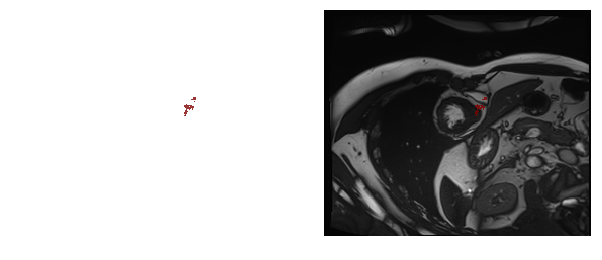

In [48]:
from common.detector.box_utils import find_multiple_connected_rois

target_rois = seg_exper_ensemble.seg_exper_handlers[3].get_target_roi_maps("patient023")

slice_id = 6
cls_idx = 5

tissue_roi = target_rois[cls_idx, :, : ,slice_id]

fig = plt.figure(figsize=(10, 10))

img, lbl = seg_exper_handler.test_set.get_test_pair(patient_id="patient023")
img_slice = img[1, :, : , slice_id]
img_slice = ACDC2017DataSet.remove_padding(img_slice)
label_bbox, label_slice_extended, bbox_areas = find_multiple_connected_rois(tissue_roi, padding=1)

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(tissue_roi, cmap=mycmap)
plt.axis("off")

ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(img_slice, cmap=cm.gray)
ax2.imshow(label_slice_extended, cmap=mycmap)
plt.axis("off")

plt.show()

In [4]:
roi_areas, roi_aspect_ratio = dataset.collect_roi_data()
roi_areas_hist, roi_areas_edges = np.histogram(roi_areas, bins=25)
roi_ratio_hist, roi_ratio_edges = np.histogram(roi_aspect_ratio, bins=5)

roi_areas_apexbase_hist, roi_areas_apexbase_edges = np.histogram(dataset.roi_areas[0], bins=25)
roi_areas_between_hist, roi_areas_between_edges = np.histogram(dataset.roi_areas[1], bins=25)

In [5]:
print(np.sum(roi_areas_apexbase_hist))
print(roi_areas_apexbase_hist)
print(roi_areas_apexbase_edges)
print("------------------------------")
print(np.sum(roi_areas_between_hist))
print(roi_areas_between_hist)
print(roi_areas_between_edges)

534
[436  35  13   8   8   5   2   5   4   3   6   3   1   2   0   1   0   0
   0   0   1   0   0   0   1]
[   12.     250.08   488.16   726.24   964.32  1202.4   1440.48  1678.56
  1916.64  2154.72  2392.8   2630.88  2868.96  3107.04  3345.12  3583.2
  3821.28  4059.36  4297.44  4535.52  4773.6   5011.68  5249.76  5487.84
  5725.92  5964.  ]
------------------------------
910
[833  45   8   7   4   0   2   3   1   1   0   2   1   0   1   0   0   1
   0   0   0   0   0   0   1]
[   12.     237.28   462.56   687.84   913.12  1138.4   1363.68  1588.96
  1814.24  2039.52  2264.8   2490.08  2715.36  2940.64  3165.92  3391.2
  3616.48  3841.76  4067.04  4292.32  4517.6   4742.88  4968.16  5193.44
  5418.72  5644.  ]


In [7]:
print(dataset.roi_stats)
print(roi_areas_hist)
print(roi_areas_edges)

[ 1444.   534.   910.]
[1276   74   20   16   11    5    6    7    5    3    8    4    1    3    0
    1    1    0    0    0    1    0    0    1    1]
[   12.     250.08   488.16   726.24   964.32  1202.4   1440.48  1678.56
  1916.64  2154.72  2392.8   2630.88  2868.96  3107.04  3345.12  3583.2
  3821.28  4059.36  4297.44  4535.52  4773.6   5011.68  5249.76  5487.84
  5725.92  5964.  ]


In [42]:
nn_cfg = {
    'A': [2, 16, 'M', 32, 'M', 64, 64, 'M'],
    'B': [2, 64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [2, 64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [2, 64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def compute_input_size(w_out, nn_config):
    # nnconfig is a dictionary based on VGG style network
    w_in = None
    for c in nn_config[1:]:
        if w_in is not None:
            w_out = w_in
            
        if c == 'M':
            dilation = 1
            kernel_size = 2
            stride = 2
            padding = 0
            w_in = (w_out * stride ) + (kernel_size - 1) + 1 - (2 * padding) - stride
        else:
            kernel_size = 3
            stride = 1
            padding = 1
            w_in = (w_out * stride ) + kernel_size - (2 * padding) - stride
    
    return w_in
    
w_in = compute_input_size(2, nn_cfg['A'])
print("w_in={}".format(w_in))

w_in=16


In [5]:
import matplotlib.patches as patches
from scipy import ndimage

def find_bbox_object_v2(multi_label_slice, threshold_pixel_value=0, padding=0):
    # multi_label_slice slice [w, h]. all pixels != 0 belong to the automatic segmentation mask
    # threshold_pixel_value (float): we're trying these bboxes also for the uncertainty maps.
    # but basically all pixels have values above 0. Experimenting with this.
    binary_mask_slice = (multi_label_slice > threshold_pixel_value).astype(np.bool)
    if 0 != np.count_nonzero(binary_mask_slice):
        roi_slice_x, roi_slice_y = ndimage.find_objects(binary_mask_slice == 1)[0]
    else:
        roi_slice_x, roi_slice_y = slice(0, 0, None), slice(0, 0, None)
        padding = 0

    roi_box = BoundingBox(roi_slice_x, roi_slice_y, padding=padding)

    return roi_box

def bbox_to_patch(bbox, box_color='b', linewidth=1):
    # bbox is [1x4] [x_low, y_low, x_high, y_high]
    # x_high, y_low for imshow
    xy_left = tuple((bbox[1], bbox[0]))
    height = bbox[2] - bbox[0] 
    width = bbox[3] - bbox[1] 
    rect = patches.Rectangle(xy_left, width, height, linewidth=linewidth, edgecolor=box_color, facecolor='none')
    
    return rect

num_of_slices 6
True [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47] 48


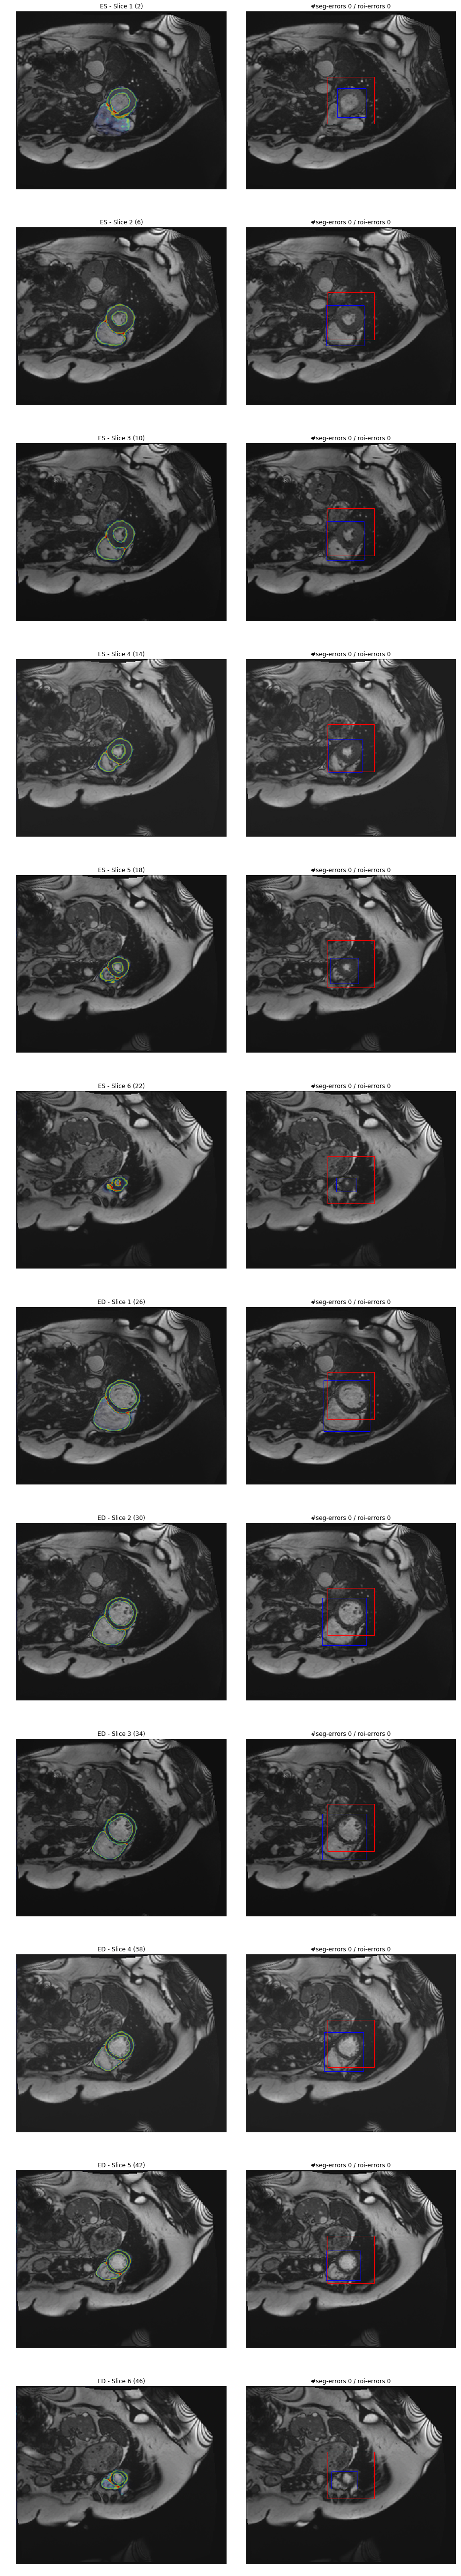

In [6]:
patient_id = "patient080"

# trans_dict has value: tuple((is_train, [array_indices]))
is_train = dataset.trans_dict[patient_id][0]
patient_dta_indices = dataset.trans_dict[patient_id][1]

num_of_slices = len(patient_dta_indices) / 8
print("num_of_slices {}".format(num_of_slices))

num_of_classes = 8
# NOTE batch_size * 2 for 2 phases
batch_size = 2 * num_of_slices


phase_offset = num_of_slices 
p_is_train = dataset.trans_dict[patient_id][0]
p_idx_offset = np.min(patient_dta_indices)
# bboxes = patient_bboxes[patient_id]

print(is_train, patient_dta_indices, len(patient_dta_indices)) 

width = 16
height = batch_size * 8
columns = 4
rows = batch_size * 2   # 2 because we do double row plotting 
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

for idx in np.arange(batch_size):
    
    if idx >= phase_offset:
        cls_slice = slice(4, 8, None)
        phase = 1
        phase_str = "ED"
        idx -= phase_offset
    else:
        cls_slice = slice(0, 4, None)
        phase = 0
        phase_str = "ES"
    
    dta_index = p_idx_offset + (phase * batch_size * 2) + (4 * idx) + 2
    # print("dta_index {}".format(dta_index))
    if p_is_train:
        dta_input = dataset.train_images[dta_index]
        dta_label = dataset.train_labels[dta_index]
        pred_lbl_rois = dataset.train_pred_lbl_rois[dta_index]
        target_rois = dataset.train_lbl_rois[dta_index]
    else:
        dta_input = dataset.test_images[dta_index]
        dta_label = dataset.test_labels[dta_index]
        pred_lbl_rois = dataset.test_pred_lbl_rois[dta_index]
        target_rois = dataset.test_lbl_rois[dta_index]
    
    dta_input_unpadded = RegionDetectorDataSet.remove_padding(dta_input)
    image_slice = dta_input_unpadded[0]
    # find center
    w, h = image_slice.shape
    cw, ch = w / 2, h / 2
    cc_patch_x, cc_patch_y = slice(cw - 36, cw + 36, None), slice(ch - 36, ch + 36, None)
    cc_patch = BoundingBox(cc_patch_x, cc_patch_y)
    auto_pred = dta_input_unpadded[2]
    # reference_slice = labels[cls_slice, :, :, idx]
    # seg_errors_slice = reference_slice != auto_pred_slice
    # umap = seg_exper_handler.entropy_maps[patient_id]
    # umap_slice = umap[phase, :, :, idx]
    umap_slice = dta_input_unpadded[1]
    
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.set_title("{} - Slice {} ({})".format(phase_str, idx + 1, dta_index))
    ax1.imshow(image_slice, cmap=cm.gray)
    ax1.imshow(umap_slice, cmap=mycmap)
    plt.axis("off")
    
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    roi_voxels = np.count_nonzero(dta_label)
    
    ax2.imshow(dta_label, cmap=mycmap)
    # ax2.imshow(dta_input[2], cmap=mycmap )
    ax2.add_patch(bbox_to_patch(pred_lbl_rois, box_color='b'))
    ax2.add_patch(cc_patch.get_matplotlib_patch(color='r'))
    # seg_errors_voxels = np.count_nonzero(seg_errors_slice)
    ax2.set_title("#seg-errors {} / roi-errors {}".format(0, roi_voxels))
    plt.axis("off")
    
    row += 2

[928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991]


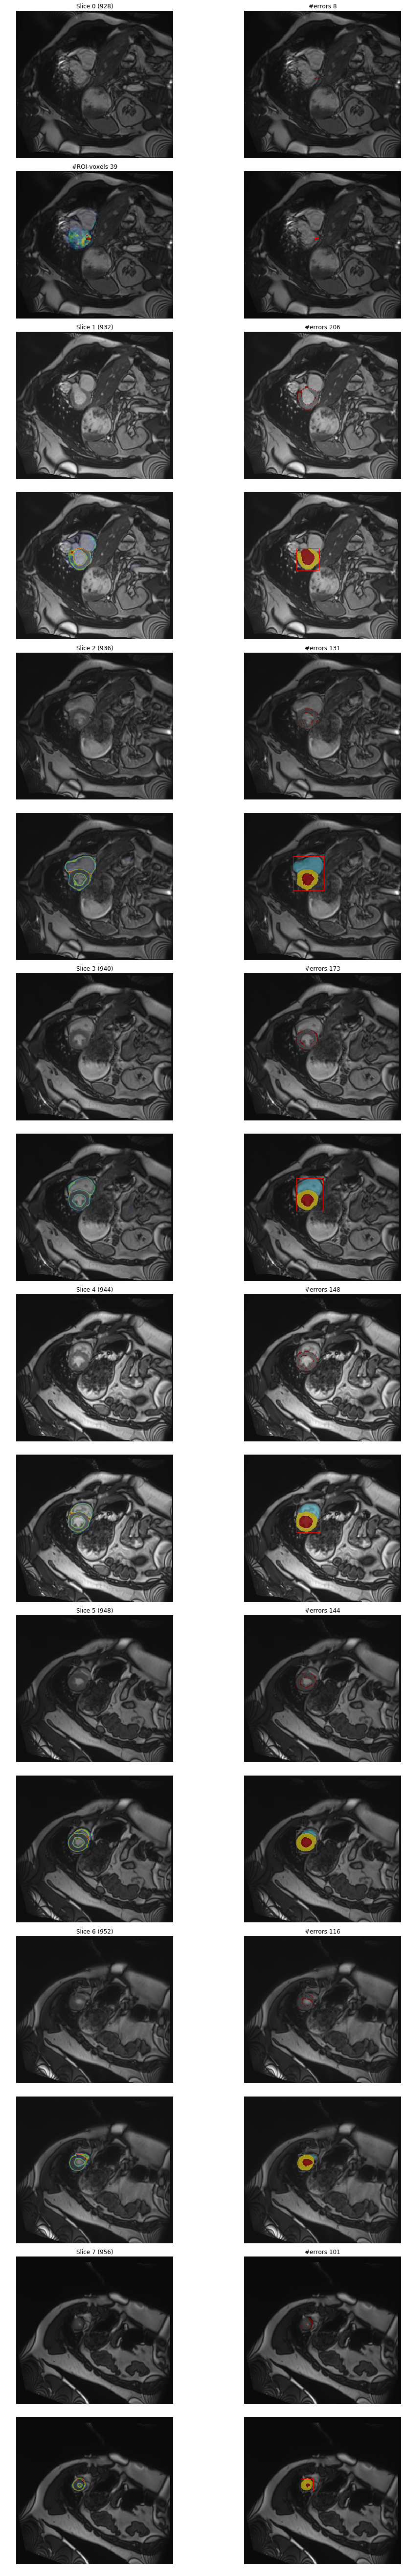

In [14]:
patient_id = "patient065"

image, labels = seg_exper_handler.test_set.get_test_pair(patient_id)
num_of_classes, w, h, batch_size = labels.shape

# 
patient_dta_indices = dataset.trans_dict[patient_id][1]
p_is_train = dataset.trans_dict[patient_id][0]
p_idx_offset = np.min(patient_dta_indices)
# bboxes = patient_bboxes[patient_id]

width = 16
height = batch_size * 12
columns = 4
rows = batch_size * 4
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

phase = 0
target_class = 2
cls_offset = phase * 4
cls_idx = cls_offset + target_class

# print(patient_dta_indices)

for idx in np.arange(batch_size):
    
    dta_index = p_idx_offset + (phase * batch_size * 4) + (4 * idx)
    if p_is_train:
        dta_input = dataset.train_images[dta_index]
        dta_label = dataset.train_labels[dta_index]
        lbl_roi_boxes = dataset.train_lbl_rois[dta_index]
    else:
        dta_input = dataset.test_images[dta_index]
        dta_label = dataset.test_labels[dta_index]
        lbl_roi_boxes = dataset.test_lbl_rois[dta_index]
    
    image_with_padding = image[phase, :, :, idx]
    image_slice = ACDC2017DataSet.remove_padding(image_with_padding)
    # seg_exper_handler.get_pred_labels( patient_id=patient_id, mc_dropout=False, force_reload=True)
    auto_pred = seg_exper_handler.pred_labels[patient_id]
    auto_pred_slice = auto_pred[cls_idx, :, :, idx]
    
    reference_slice = labels[cls_idx, :, :, idx]
    seg_errors_slice = reference_slice != auto_pred_slice
    umap = seg_exper_handler.entropy_maps[patient_id]
    umap_slice = umap[phase, :, :, idx]
    
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    # ax1.imshow(image_slice, cmap=cm.gray)
    # ax1.imshow(reference_slice, cmap=mycmap)
    ax1.set_title("Slice {} ({})".format(idx, dta_index))
    ax1.imshow(image_slice, cmap=cm.gray)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    ax2.imshow(seg_errors_slice, cmap=mycmap)
    seg_errors_voxels = np.count_nonzero(seg_errors_slice)
    ax2.set_title("#errors {}".format(seg_errors_voxels))
    plt.axis("off")
    
    ax3 = plt.subplot2grid((rows, columns), (row+2, 0), rowspan=2, colspan=2)
    dta_input_unpad = RegionDetectorDataSet.remove_padding(dta_input)
    # ax3.imshow(image_slice, cmap=cm.gray)
    # if 0 != np.count_nonzero(dta_input_unpad[0] > 0.009):
    #    bbox = find_bbox_object(dta_input_unpad[0], threshold_pixel_value=0.009)
    #    ax3.add_patch(bbox.get_matplotlib_patch())
    ax3.imshow(image_slice, cmap=cm.gray)
    ax3.imshow(dta_input_unpad[0], cmap=mycmap)
    ax3.imshow(dta_label, cmap=mycmap)
    roi_voxels = np.count_nonzero(dta_label)
    if roi_voxels != 0:
        ax3.set_title("#ROI-voxels {}".format(roi_voxels))
    plt.axis("off")
    
    ax4 = plt.subplot2grid((rows, columns), (row+2, 2), rowspan=2, colspan=2)
    ax4.imshow(image_slice, cmap=cm.gray)
    # dta_input_unpad contains the multi-label automatic segmentation mask with values between [0, 0.9]
     # Determine roi for this segmentation mask
    if 0 != np.count_nonzero(dta_input_unpad[1]):
        bbox = find_bbox_object(dta_input_unpad[1])
        ax4.add_patch(bbox.get_matplotlib_patch())
    ax4.imshow(dta_input_unpad[1], cmap=mycmap)
    plt.axis("off")
    
    row += 4